# Extract data from the ESIDA DB

In [1]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [160]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [2]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get Shapes from database

In [3]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [4]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))

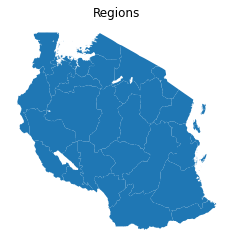

In [6]:
regions_gdf.plot()
plt.title('Regions')
plt.axis('off')
plt.show()

# Load data for single shape

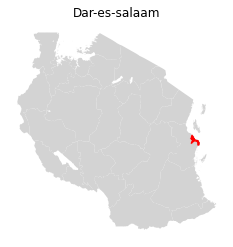

In [15]:
# plot shape we want to look at
shape_gdf = regions_gdf[regions_gdf['name'] == 'Dar-es-salaam'].reset_index(drop=True)
shape_id = shape_gdf.at[0, 'id']

ax = regions_gdf.plot(color='lightgray')
shape_gdf.plot(color='red', ax=ax)
plt.title(shape_gdf.at[0, 'name'])
plt.axis('off')
plt.show()

In [16]:
# Download all data for given parameter
q = {
    'filter_parameters': ','.join(['worldpop_popc']), # list of parameters, 
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/shape/{shape_id}?{urlencode(q)}", auth=auth).json()
shape_df = pd.DataFrame(d['data'])

In [17]:
shape_df

,worldpop_popc,year
0,4049635.8,2010
1,4294334.0,2011
2,4554449.0,2012
3,4829976.0,2013
4,5121146.0,2014
5,5428955.0,2015
6,5753794.0,2016
7,6097105.5,2017
8,6459003.0,2018
9,6840113.0,2019


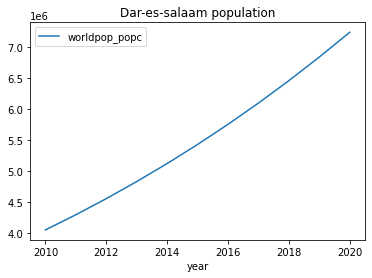

In [20]:
shape_df.plot(x='year', y=['worldpop_popc']) # value column always has the same name as the parmeter
plt.title(f"{shape_gdf.at[0, 'name']} population")
plt.show()

# Load all data of the parameter, for all available shapes

In [21]:
parameter_id = 'worldpop_popc'
q = {
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
param_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

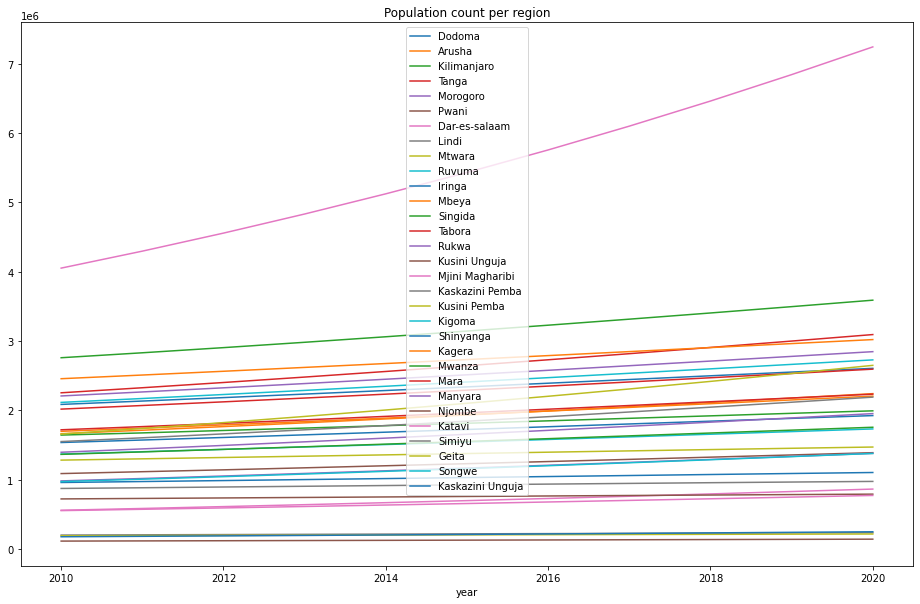

In [32]:
fig, ax = plt.subplots(figsize=(16, 10))

# use regions from above to filter results to only show regions
for sid in regions.keys():
    dfx = param_df[param_df['shape_id'] == sid]
    dfx.plot(x='year', y='worldpop_popc', ax=ax, label=regions[sid])
    
plt.title('Population count per region')
plt.show()

In [39]:
# - filter only regions
# - sort by year to get youngest values
# - get the first x entries -> amount of regions
# => new DF contains the latest value for each region only
latest_df = param_df[param_df['shape_id'].isin(regions.keys())].sort_values(by='year', ascending=False).head(len(regions.keys()))

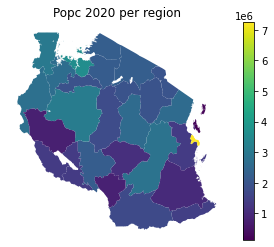

In [46]:
regions_gdf['shape_id'] = regions_gdf['id'] # copy column to merge on
regions_gdf.merge(latest_df, on='shape_id').plot(column='worldpop_popc', legend=True)
plt.title('Popc 2020 per region')
plt.axis('off')
plt.show()

# Load precipitation and Dengue cases for all shapes 

Combine two data layers and plot them.

In [47]:
parameter_id = 'chirps_tprecit'
q = {
    'start_date': '2018', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
chirps_tprecit_df = pd.DataFrame(d['data'])
chirps_tprecit_df['date'] = pd.to_datetime(chirps_tprecit_df['date'])

In [48]:
parameter_id = 'lit_dengue_out_loc'
q = {
    'start_date': '2018', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
lit_dengue_out_loc_df = pd.DataFrame(d['data'])
lit_dengue_out_loc_df['date'] = pd.to_datetime(lit_dengue_out_loc_df['date'])

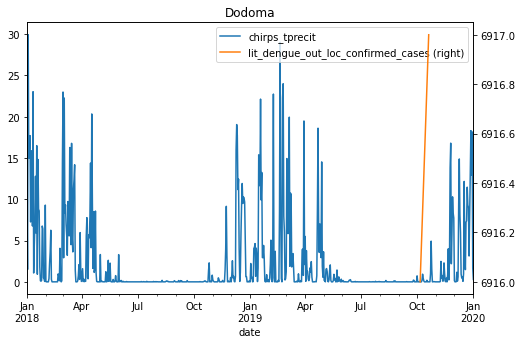

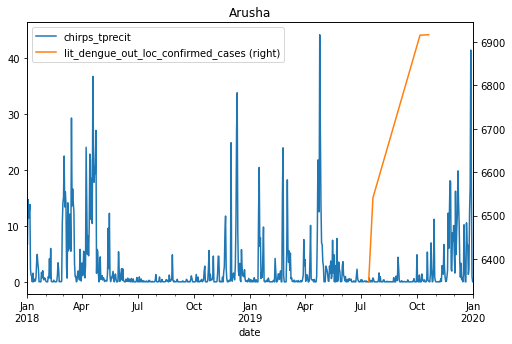

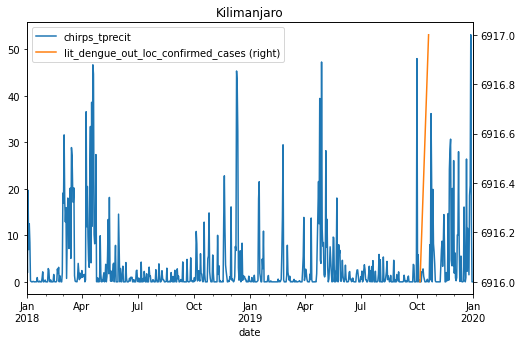

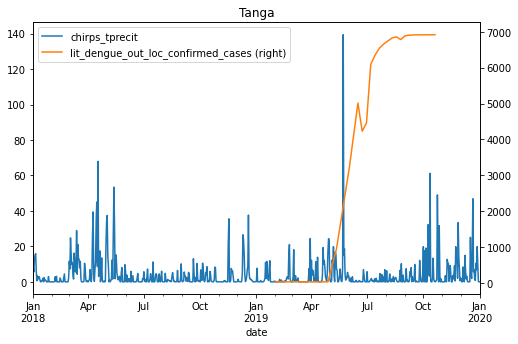

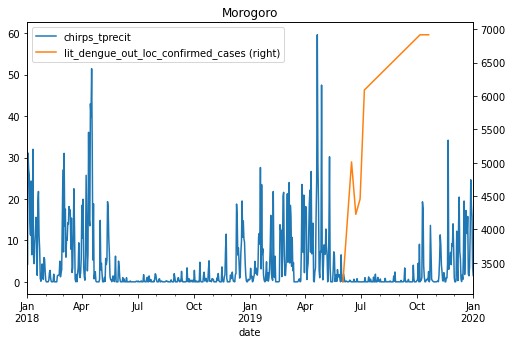

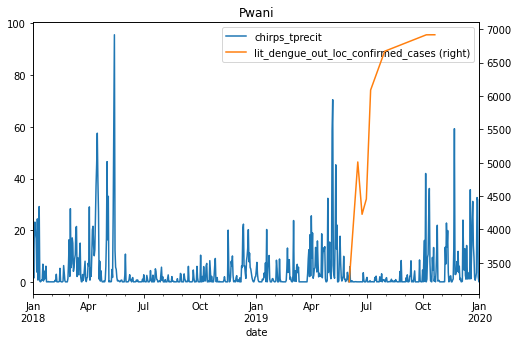

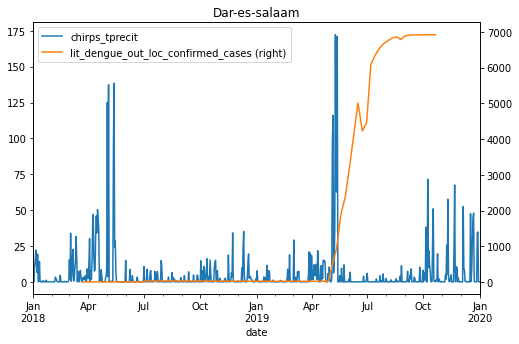

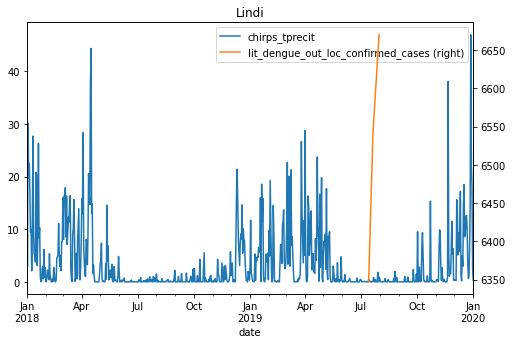

No cases for Mtwara.


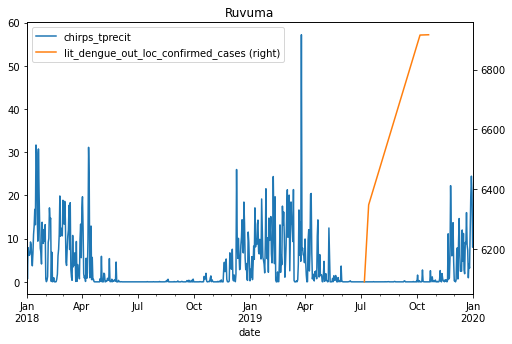

No cases for Iringa.
No cases for Mbeya.


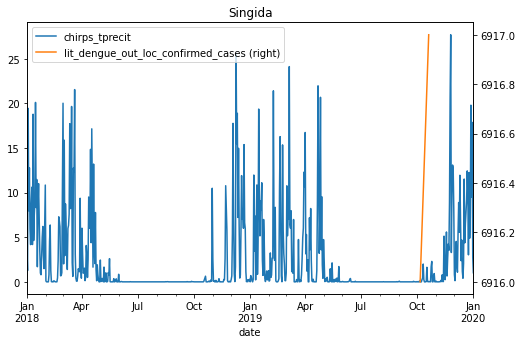

No cases for Tabora.
No cases for Rukwa.
No cases for Kusini Unguja.
No cases for Mjini Magharibi.
No cases for Kaskazini Pemba.
No cases for Kusini Pemba.
No cases for Kigoma.
No cases for Shinyanga.


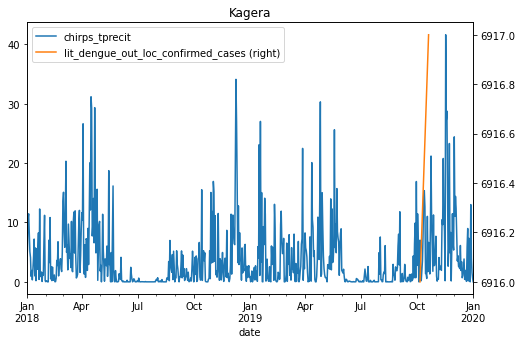

No cases for Mwanza.
No cases for Mara.
No cases for Manyara.
No cases for Njombe.
No cases for Katavi.
No cases for Simiyu.
No cases for Geita.
No cases for Songwe.
No cases for Kaskazini Unguja.


In [50]:
for sid in shape_ids:
    # only build charts for known id's from above
    if sid not in regions.keys():
        continue
        
    # tprecit 
    dfx_tprecit = chirps_tprecit_df[chirps_tprecit_df['shape_id'] == sid].reset_index(drop=True)
    if len(dfx_tprecit) == 0:
        print(f"No prec. for {regions[sid]}.")
        continue
        
    # cases 
    dfx_cases = lit_dengue_out_loc_df[lit_dengue_out_loc_df['shape_id'] == sid].reset_index(drop=True)
    if len(dfx_cases) == 0:
        print(f"No cases for {regions[sid]}.")
        continue
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    dfx_tprecit.plot(x='date', y='chirps_tprecit', ax=ax)
    dfx_cases.plot(x='date', y='lit_dengue_out_loc_confirmed_cases', ax=ax, secondary_y=True)

    
    plt.title(regions[sid])
    plt.show()